<a href="https://colab.research.google.com/github/Rishad-A-Pulok/Sign_Langugae_ASL/blob/main/ASL_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras.models import Sequential
from keras import backend as K
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.applications import resnet
from keras.applications.vgg16 import VGG16
from keras.models import Model

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
!unzip "/content/drive/MyDrive/Sign Language Project/asl-full.zip"

Streaming output truncated to the last 5000 lines.
  inflating: asl-full/validation/S/S2809.jpg  
  inflating: asl-full/validation/S/S2810.jpg  
  inflating: asl-full/validation/S/S2811.jpg  
  inflating: asl-full/validation/S/S2812.jpg  
  inflating: asl-full/validation/S/S2813.jpg  
  inflating: asl-full/validation/S/S2814.jpg  
  inflating: asl-full/validation/S/S2815.jpg  
  inflating: asl-full/validation/S/S2816.jpg  
  inflating: asl-full/validation/S/S2817.jpg  
  inflating: asl-full/validation/S/S2818.jpg  
  inflating: asl-full/validation/S/S2819.jpg  
  inflating: asl-full/validation/S/S2820.jpg  
  inflating: asl-full/validation/S/S2821.jpg  
  inflating: asl-full/validation/S/S2822.jpg  
  inflating: asl-full/validation/S/S2823.jpg  
  inflating: asl-full/validation/S/S2824.jpg  
  inflating: asl-full/validation/S/S2825.jpg  
  inflating: asl-full/validation/S/S2826.jpg  
  inflating: asl-full/validation/S/S2827.jpg  
  inflating: asl-full/validation/S/S2828.jpg  
  inflati

In [4]:
# input path for the images
base_path = '/content/asl-full/train/'

In [5]:
SIZE = 224
image_size = (SIZE, SIZE)
batch_size = 32
channels = 3
kernel = 4
stride = 1
pool = 2

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_path,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size = image_size,
    batch_size = batch_size,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_path,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = image_size,
    batch_size = batch_size,
)

Found 69600 files belonging to 29 classes.
Using 55680 files for training.
Found 69600 files belonging to 29 classes.
Using 13920 files for validation.


In [7]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.2,
    shear_range = 0.2,
    horizontal_flip= True,
    vertical_flip= False,
    validation_split= 0.2,
)
test_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split= 0.2,
)

In [8]:
train_set = train_datagen.flow_from_directory(
    base_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode= 'categorical',
    shuffle = True,
    subset = 'training'
)
test_set = train_datagen.flow_from_directory(
    base_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode= 'categorical',
    shuffle = False,
    subset = 'validation'
)

Found 55680 images belonging to 29 classes.
Found 13920 images belonging to 29 classes.


In [9]:
test_set.class_indices

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25,
 'del': 26,
 'nothing': 27,
 'space': 28}

In [10]:
class_names = train_ds.class_names
num_classes = len(class_names)
class_names

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

In [11]:
labels = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','nothing','space']

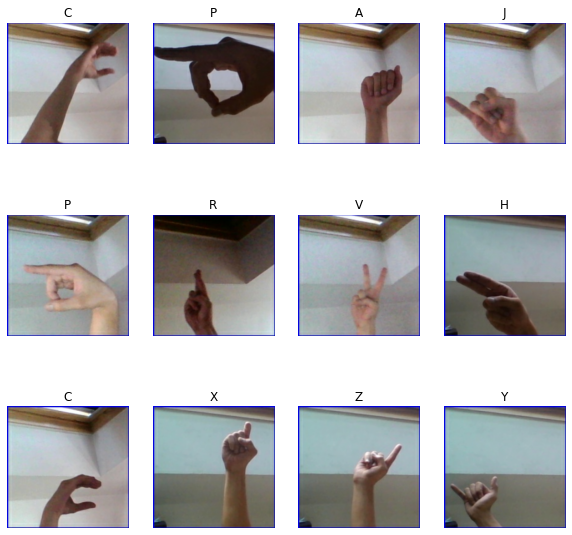

In [12]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in train_ds.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")

#CNN Model

In [13]:
model=Sequential()

model.add(Conv2D(16,kernel_size=kernel,strides=stride,padding='same',activation='relu',input_shape=(SIZE, SIZE, channels)))
model.add(MaxPool2D(pool_size=pool,strides=2,padding='same'))

model.add(Conv2D(32,kernel_size=kernel,strides=stride,activation='relu',padding='same'))
model.add(MaxPool2D((pool),2,padding='same'))

model.add(Conv2D(64,kernel_size=kernel,strides=stride,activation='relu',padding='same'))
model.add(MaxPool2D((pool),2,padding='same'))
          
model.add(Flatten())

model.add(Dense(units=128,activation='relu'))
model.add(Dense(units=num_classes,activation='softmax'))

In [14]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      784       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        32832     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [15]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 7.7 MB/s 


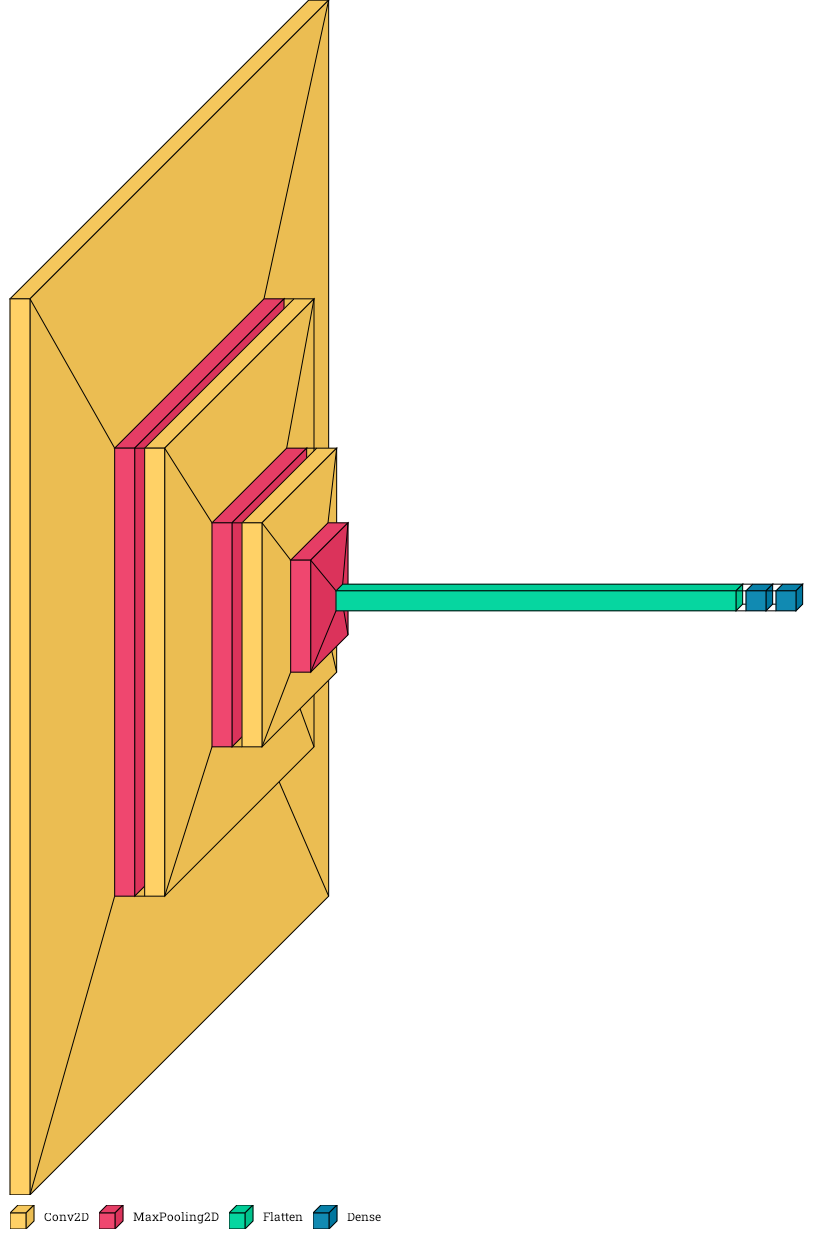

In [16]:
from PIL import ImageFont
import visualkeras
font = ImageFont.truetype("/content/drive/MyDrive/Sign Language Project/RobotoSlab-VariableFont_wght.ttf", 12)
visualkeras.layered_view(model, legend=True, font=font)

In [17]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoint.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [18]:
history = model.fit( train_set, epochs=15, callbacks=model_checkpoint, validation_data=test_set)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1740/1740 [==============================] - 744s 422ms/step - loss: 1.3666 - accuracy: 0.5778 - val_loss: 2.1304 - val_accuracy: 0.4932
Epoch 2/15
1740/1740 [==============================] - 718s 413ms/step - loss: 0.3696 - accuracy: 0.8783 - val_loss: 2.0180 - val_accuracy: 0.5606
Epoch 3/15
1740/1740 [==============================] - 715s 411ms/step - loss: 0.2172 - accuracy: 0.9275 - val_loss: 1.8761 - val_accuracy: 0.5881
Epoch 4/15
1740/1740 [==============================] - 718s 413ms/step - loss: 0.1622 - accuracy: 0.9460 - val_loss: 2.5608 - val_accuracy: 0.6047
Epoch 5/15
1740/1740 [==============================] - 713s 410ms/step - loss: 0.1350 - accuracy: 0.9543 - val_loss: 2.0297 - val_accuracy: 0.6200
Epoch 6/15
1740/1740 [==============================] - 711s 409ms/step - loss: 0.1161 - accuracy: 0.9611 - val_loss: 2.5292 - val_accuracy: 0.5830
Epoch 7/15
1740/1740 [==============================] - 707s 406ms/step - loss: 0.1083 - accuracy: 0.9647 - val_loss: 2.473

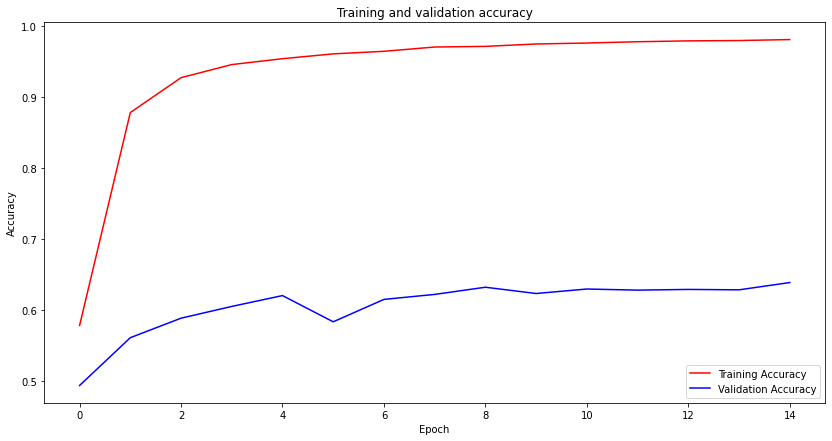

In [19]:
# Validation and Training accuracy plot
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

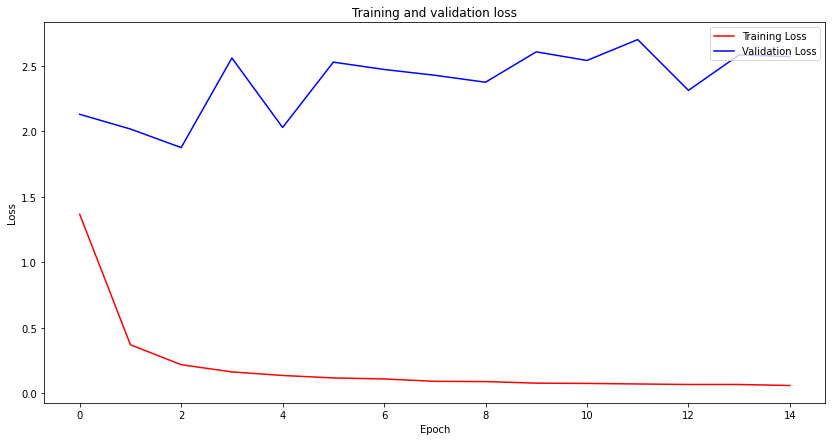

In [20]:
#Validation and Training loss plot
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [21]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(image_batch[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 17ms/step


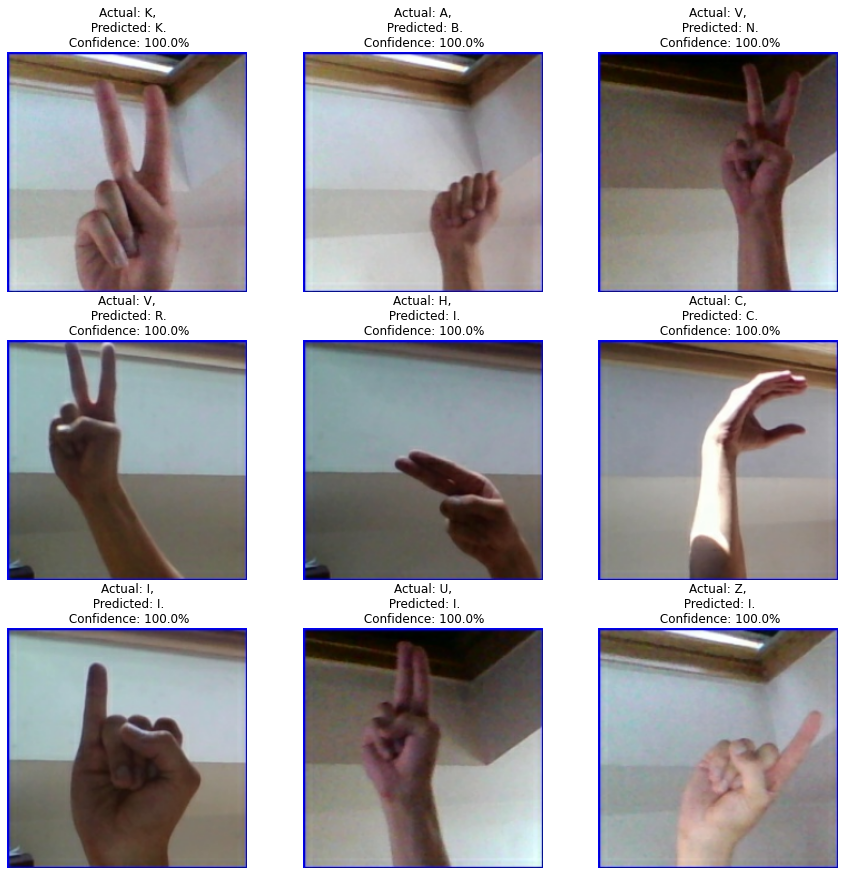

In [22]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        predicted_class, confidence =predict(model, image_batch[i].numpy())
        actual_class = class_names[labels_batch[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [23]:
loss,test_accuracy = model.evaluate(test_set)
print('Accuracy on test:', test_accuracy)

435/435 [==============================] - 147s 339ms/step - loss: 2.5883 - accuracy: 0.6402
Accuracy on test: 0.6402298808097839


In [24]:
# T0 print the Classification Report
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(test_set.classes, y_pred))

435/435 [==============================] - 138s 316ms/step
              precision    recall  f1-score   support

           0       0.71      0.34      0.46       480
           1       0.63      0.87      0.73       480
           2       0.90      0.94      0.92       480
           3       0.94      0.70      0.80       480
           4       0.50      0.89      0.64       480
           5       0.86      0.91      0.88       480
           6       0.62      0.66      0.64       480
           7       0.72      0.84      0.77       480
           8       0.90      0.45      0.60       480
           9       0.88      0.75      0.81       480
          10       0.94      0.76      0.84       480
          11       0.91      0.91      0.91       480
          12       0.52      0.62      0.57       480
          13       0.39      0.25      0.31       480
          14       0.53      0.51      0.52       480
          15       0.58      0.68      0.62       480
          16       0.6

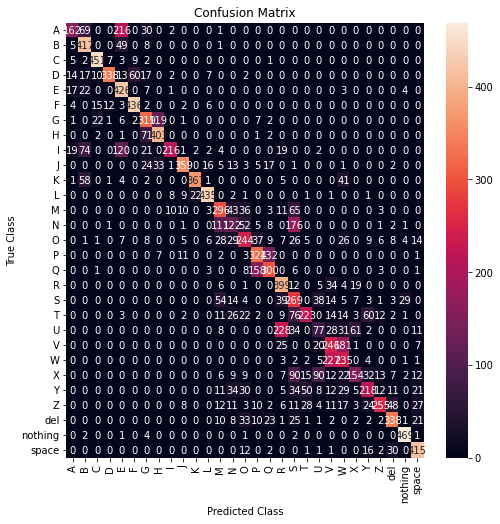

In [26]:
import seaborn as sns
# To print the Confusion Matrix
cf_matrix = confusion_matrix(test_set.classes, y_pred)
labels = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','nothing','space']
plt.figure(figsize=(8, 8))
heatmap = sns.heatmap(cf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', color='blue')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()